In [1]:
import jax
import jax.numpy as np
import flax.linen as nn
import optax

from typing import Sequence, Callable
from functools import partial
import tensorflow_probability.substrates.jax as tfp
from tqdm import trange

tfd = tfp.distributions

In [2]:
import diffrax as dfx

class MLP(nn.Module):
    """A simple MLP (fully-connected neural network)."""

    feature_sizes: Sequence[int]
    activation: Callable[[np.ndarray], np.ndarray] = nn.elu

    @nn.compact
    def __call__(self, x, t):
        x = np.concatenate([x, t], axis=-1)
        for features in self.feature_sizes[:-1]:
            x = nn.Dense(features)(x)
            x = self.activation(x)
        x = nn.Dense(self.feature_sizes[-1])(x)
        return x


class SymplecticFlow(nn.Module):

    def setup(self):
        
        self.n_leapfrog_steps = 10
        self.T = 2.0
        self.dt = self.T / self.n_leapfrog_steps
        self.potential_func = MLP([128, 128, 1])
        self.n_dim = 2

    # def leapfrog_step(self, pos, vel, potential_func, dt):
    #     """
    #     Implements a single step of the leapfrog integration method.

    #     Args:
    #         pos (jax.numpy.ndarray): Array of particle positions. Should be in a length unit.
    #         vel (jax.numpy.ndarray): Array of particle velocities.
    #         potential_func (function): Function that computes the potential energy of the system.
    #         dt (float): Time step size.

    #     Returns:
    #         Tuple containing the new positions and velocities, and the Jacobian of the transformation.
    #     """

    #     # Compute the gradient of the potential energy function
    #     grad_potential = jax.grad(potential_func)

    #     # Compute the forces on the particles by evaluating the gradient of the potential energy
    #     vel_dot = -grad_potential(pos)

    #     # Update the velocities by half a time step
    #     vel_half = vel + vel_dot * (dt / 2.0)

    #     # Update the positions using the new velocities
    #     pos_new = pos + vel_half * dt

    #     # Compute the forces on the new positions
    #     forces_new = -grad_potential(pos_new)

    #     # Update the velocities using the new forces
    #     vel_new = vel_half + forces_new * (dt / 2.0)

    #     # Return the new positions and velocities, and the updated Jacobian derivatives as a tuple
    #     return pos_new, vel_new
    
    def leapfrog_step(self, pos, vel, potential_func, dt):

        grad_potential = jax.grad(potential_func)

        w1 = 1 / (2 - 2**(1/3))
        w0 = -(2**(1/3)) * w1
        w = [w1, w0, w1]
        
        for wi in w:
            vel = vel - wi * dt * grad_potential(pos) / 2
            pos = pos + wi * dt * vel
            vel = vel - wi * dt * grad_potential(pos) / 2
        
        return pos, vel

    def log_prob(self, xv):

        pos, vel = np.split(xv, 2, axis=-1)

        # Backward leapfrog integration
        for i in range(self.n_leapfrog_steps):
            pos, vel = self.leapfrog_step(pos, vel, lambda x: self.potential_func(x, np.atleast_1d(self.T - i * self.dt))[0], -self.dt)

        # Base distribution is just a standard normal
        # We don't need to worry about det-Jacobian because it's unity for leapfrog
        base_dist = tfd.MultivariateNormalDiag(loc=np.zeros_like(xv), scale_diag=np.ones_like(xv))

        # Compute log-density
        log_prob = base_dist.log_prob(np.concatenate([pos, vel], axis=-1))

        return log_prob
    
    def sample_single(self, key):

        key, subkey = jax.random.split(key)
        xv = jax.random.normal(subkey, shape=(self.n_dim,))
        pos, vel = np.split(xv, 2, axis=-1)
        
        # Forward leapfrog integration
        for i in range(self.n_leapfrog_steps):
            pos, vel = self.leapfrog_step(pos, vel, lambda x: self.potential_func(x, np.atleast_1d(i * self.dt))[0], self.dt)

        return np.concatenate([pos, vel], axis=-1)

    def sample(self, key, n_samples):
        sample_key = jax.random.split(key, n_samples ** 2)
        return jax.vmap(self.sample_single)(sample_key)
    
    def __call__(self, x):
        return jax.vmap(self.log_prob)(x)

In [3]:
flow = SymplecticFlow()
xv = jax.random.normal(jax.random.PRNGKey(0), (100, 2))

rng = jax.random.PRNGKey(0)
log_prob, params = flow.init_with_output(rng, xv)

In [4]:
# Use sample using apply
flow.apply(params, rng, method=flow.sample_single)

Array([-2.4430127, -1.9914838], dtype=float32)

In [5]:
# Use sample using apply
flow.apply(params, rng, 100, method=flow.sample)

Array([[ 1.4917946, -0.1262246],
       [-3.5453026, -1.6295573],
       [-1.2191111, -1.6846423],
       ...,
       [-1.3538303, -2.0491962],
       [ 2.460392 ,  0.2392093],
       [-3.2506225, -1.5568379]], dtype=float32)

(-2.0, 2.0)

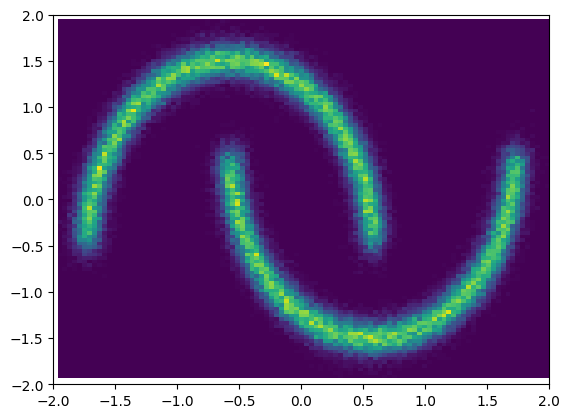

In [6]:
from sklearn import datasets, preprocessing
import matplotlib.pyplot as plt

n_samples = 100_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [7]:
opt = optax.adamw(learning_rate=6e-4, weight_decay=1e-4)
opt_state = opt.init(params)

In [8]:
@jax.jit
def loss_fn(params, x):
    log_prob = flow.apply(params, x)
    return -log_prob.mean()

In [10]:
n_steps = 2000
n_batch = 64

key = jax.random.PRNGKey(0)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        
        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

 86%|████████▌ | 1712/2000 [03:29<00:31,  9.03it/s, val=2.2713938]

In [14]:
x_sample = flow.apply(params, rng, 300, method=flow.sample)

In [15]:
x_sample

Array([[-0.81785774,  1.124572  ],
       [-2.299686  ,  0.09397967],
       [-2.9192271 , -0.36959982],
       ...,
       [-0.36339003,  1.6213161 ],
       [-1.1077616 ,  0.85509706],
       [ 0.6683691 , -1.0303913 ]], dtype=float32)

(-2.0, 2.0)

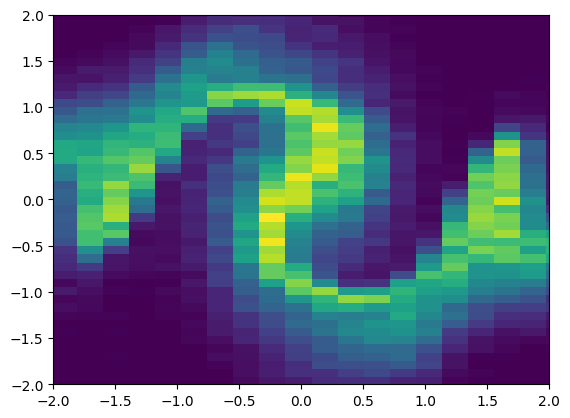

In [16]:
plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100);
plt.xlim(-2 ,2)
plt.ylim(-2, 2)